# Data Assimilation


#### James Percival (<j.percival@imperial.ac.uk>)
#### RSM 4.85

In [146]:
# some basic setup for plotting etc.

%matplotlib inline
from matplotlib import pyplot as p
import numpy as np

Weather forecasting (AKA Numerical Weather Prediction or NWP) is one topic where there is a continuous, operational need to optimize and invert from observational data in order to generate accurate initial conditions from which to run forecasting models. As such it has a long and particular history of its own in generating inversion and assimilation techniques, many of them based on a probablistic understanding of error.

These systems tend to be run on fast cycles and at massive scale, requiring their own dedicated HPC centres. Indeed atmospheric and climate science are key drivers in exascale supercomputing.

The UK is currently the home of two major European weather forcasting centres; The [UK Metereological Office](https://www.metoffice.gov.uk/) (the Met Office) in Exeter and the [European Centre for Medium-Range Weather Forecasting](https://www.ecmwf.int/) (the ECMWF) in Reading. These centres combine advanced, complex mathematical models with a wealth of observations from weather stations and satilites in order to generate forecasts, with the Met Office now running on an hourly cycle for some forecast products. The techniques used to combine numerics and observations are called data assimilation methods.

## Probability Recap

Since the rest of this lecture will be justified by taking a probablistic view of the universe (we cannot guarantee any particular forecast is accurate, but we believe it's possible to devise a technique to pick a forecast that will beat other possible forecasts on average), we will begin with a swift recap of some core probability theory, and of the notation used in the rest of this lecture.

### Discrete Probability

#### Probabilities, expectation, averages, variance and standard deviation

The classical definition of the probabliity of an event is the ratio of the number of cases in which the event happens over the total number of cases which could occur. So, for standard 6 sided dice we have

$$ \mbox{possible results} = \{1, 2, 3, 4, 5, 6\} $$

$$ \mbox{results divisible by 3} = \{3, 6\}$$

$$ P(\mbox{result divisible by 3}) = \frac{2}{6} \approx 0.3333 $$

More modern definitions are looser, but will always involve a number between 0 (never) and 1. In some interpretations (the objectivist) this may represent repetition, in others (the subjectivist) it represents our belief or knowledge about the event.

With access to a computer, it's possible to attempt to test this analysis

ratio for 1000 trials is 0.327
ratio for 1000000 trials is 0.33336850000000007


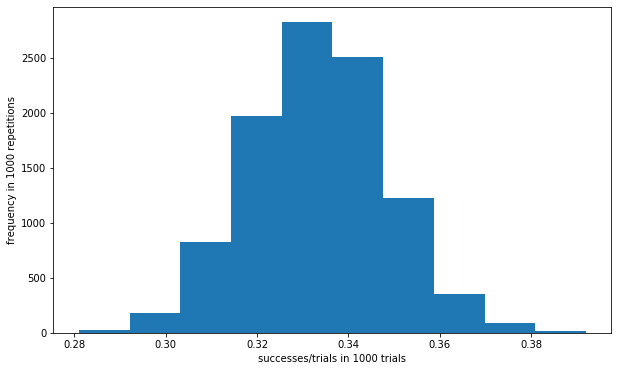

In [160]:
import random
def d6():
    """A Python implementation of a six sized dice"""
    # could also use np.random.randint(1, 7) to vectorize better
    return random.randint(1,6)

# Now to perform 1000 trials 1000 times
N = 1000
def sample():
    success = 0
    for i in range(N):
        success += (d6()%3 == 0)
    return success/N
    
data = [sample() for _ in range(10000)]
print(f"ratio for 1000 trials is {data[0]}")
print(f"ratio for 1000000 trials is {np.mean(data)}")
p.figure(figsize=(10,6))
p.hist(data)
p.xlabel('successes/trials in 1000 trials')
p.ylabel('frequency in 1000 repetitions');


Given its propability distribution (i.e. the probability for every option it can take) we can define the *expected value* or *expectation* of an event with a numerical value, $x$, as

$$E(X) := \sum_{\mbox{possible values}} x \cdot P(X=x)$$

so, using the information above $E(\mbox{dice value}) = \sum_{x=1}^6 \left[x \cdot \frac{1}{6}\right]= \frac{1+2+3+4+5+6}{6}= 3.5 $ 

You may have noticed that $E(X)$ is also the mean value, $\mu_X$, of the random variable $X$ (by definition). Let's now work out $E(X^2)$ for regular six-sided dice:

$$E(X^2) = \sum_{x=1}^6 x^2 \cdot \frac{1}{6}= \frac{1+4+9+16+25+36}{6} = \frac{91}{6}$$

by itself, this is not very enlightening. However, we can think about another set of dice with face values $\{-2.5,-1.5,-0.5,0.5,1.5,2.5\}$ (i.e. a normal one, subtracing the mean . Then the mean is 0 and $\mathbb{E}(\mbox{X^2})=\frac{35}{12}$. Notice that $\frac{35}{12}$ is $ \frac{91}{6}- (3.5)^2$. This quantity,
$$ \sigma^2_X:=E(x^2) -\left(E(x)\right)^2$$ 
is called the *variance*, and is a very useful measure for the "spread" or "width" of a distribution around its mean.

Further moments, (i.e functions of  $E(x^3)$ etc) can be calculated, but are very rarely used in practice.

as shown in the code block above, the probability of an event can itself be estimated  by

$$ P(X) \approx \frac{\mbox{number of successes in sample}}{\mbox{number of elements in sample}}$$

Similarly the mean can be estimated by

$$\mu \approx \frac{\sum \mbox{sample values}}{\mbox{number of samples}} .$$

Given these formulae, you might think that the variance can be estimated by 

$$\sigma^2 \approx \frac{\sum \mbox{sample values}^2}{\mbox{number of samples}} - \left(\frac{\sum \mbox{sample values}}{\mbox{number of samples}}\right)^2 ,$$

in fact this will actually tend to be too small. On average

$$\sigma^2 \approx \frac{\sum \mbox{sample values}^2}{\mbox{number of samples}-1} - \left(\frac{\sum \mbox{sample values}}{\mbox{number of samples}}\right)^2 $$
will be a better fit.

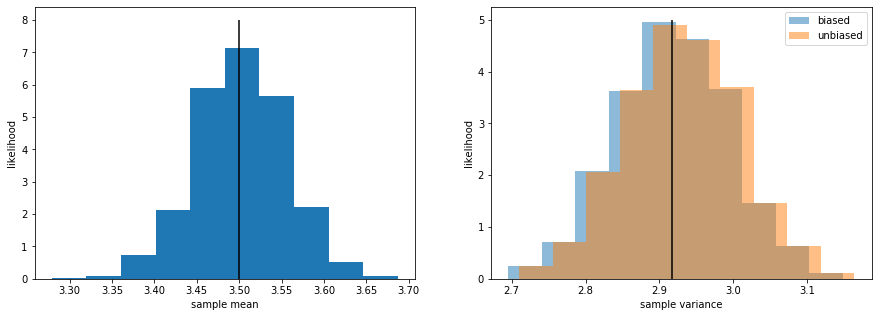

In [175]:
mu = []
var_biased = []
var_unbiased = []

for _ in range(1000):
    n_samples = 1000
    data = np.array([d6() for i in range(n_samples)])
    
    mu.append(np.sum(data)/n_samples)
    var_biased.append((np.sum(data**2)/n_samples-mu[-1]**2))
    var_unbiased.append((np.sum(data**2)/(n_samples-1)-mu[-1]**2))

p.figure(figsize=(15,5))
p.subplot2grid((1, 2), (0, 0))
p.hist(mu, density=True)
p.vlines(3.5, 0, 8)
p.xlabel('sample mean')
p.ylabel('likelihood')
p.subplot2grid((1, 2), (0, 1))
p.hist(var_biased, density=True, alpha=0.5, label='biased')
p.hist(var_unbiased, density=True, alpha=0.5, label='unbiased')
p.vlines(35/12, 0, 5)
p.legend()
p.xlabel('sample variance')
p.ylabel('likelihood');

### independence, correlation and covariance

If we roll two dice, the value on one is not affected by the value on the other. On the other hand, the value on the bottom of dice is entirely determined by the value shown on the top. We can make this more rigourous by defining, that the probability of $X=x$ and $Y=y$, written as 
$ P(X=x \cap Y=y)$ or just $P(x\cap y)$, satisfies
$$ P(x\cap y) = P(x)P(y) $$.

When variables are interdependent, we can quantify the extent through the *covariance* operator,
$$ \mbox{cov}(X, Y) = E \left((X-\mu_X)(Y-\mu_Y)\right) = E(XY)-\mu_X\mu_Y$$
or the correlation coefficient,
$$ \mbox{corr}(X, Y) = \frac{\mbox{cov}(X,Y)}{\sigma_X, \sigma_Y}.$$
When variables behave in the same way, the correlation coefficient is 1, when variables act precisely opposite, the correlation coefficient is -1. Note that
$$ \tag{Cauchy-Cauchy–Bunyakovsky–Schwarz}\mbox{cov}(X, Y)^2 \leq \sigma_X^2 \sigma^2 Y $$
so that those values represent bounds on the correlation coefficient. 

#### Exercises:

 - Prove the equality given above that $ E \left( [X-\mu_X][Y-\mu_Y]\right) = E(XY)-\mu_X\mu_Y$. You may use the facts that $\mu_X:=E(X)$ and $\mu_Y:=E(Y)$ are constants and that $E(a) = a$ for constant variables.
 
### Properties of the expectation operator

Constant parameters have an expectation equal to their value, i.e. they behave as random variables which only take one value 100% of the time,

$$ E(1) = 1 .$$

The expectation of a sum of random variables is the sum of the expectations,

$$\mu_{X+Y}:= E(X+Y) = E(X) + E(Y) = \mu_X+\mu_y.$$

This can be riguously proved by re-writing this as summations, then using $\sum_{i,j} i+j =\sum i + \sum j. To put this in mathematical language, the expectation operator is distributive over addition. Expectation also comutes with scalar multiplication,

$$ E(aX) = aE(X),$$

Again, this can be proved by going back to summations.

The variance of a sum of dependent random variables is **not** generally the  sum of the variances (although it is for independent variables). 
$$\begin{eqnarray*}\sigma^2_{X+Y} =& E\left((X+Y)^2) -E(X+Y)^2\right)\\
=& E(X^2)- E(X)^2 +2E(XY)-2E(X)E(Y) + E(Y^2)-E(Y)^2 \\
=& \sigma_X^2 +2\mbox{cov}(X, Y) + \sigma_y^2.
\end{eqnarray*}$$

If $X$ and $Y$ are independent then $E(XY) = E(X)E(Y)$. This can be true for dependent variables, but isn't generally.

For a function of a random variable, $f(X)$ we have the identity
$$E(f(X)) = \sum_x f(x) P\left(X=x\right),$$
which is subtlely differet from the _definition_
$E(f(X)) := \sum_{f(x)} f(x) P\left(f(X)=f(x)\right)$

 
### Integral random number generators for computers

Methods to generate random numbers on computers can be seperated into two families:

 1. Pseudo-random (or deterministic) random number generators (PRNGs)
 2. Hardware (or true) random number generators (TRNGs)

The first family apply fixed mathematical formulae to produce a sequence of numbers from a specified starting point. These are random in the sense of "hard to guess", but the same set of numbers can be generated multiple times by different pople.

The second family use data from external physical processes (and/or humans) to produce their sequences. This makes them "unrepeatable", even with full knowledge of previous numbers in the sequence, which has advantages and disadvantages.

Early random number generators tended to be based on linear congruential generators (LNG), i.e. formulas with a characteristic form
$$ I_{n+1} = aI_n +c\quad (\mbox{modulo } m). $$
LNGs are now well known to be unsafe for use in isolation, but for fun, lets implement one of the more infamously bad ones to be seen in the wild.

['00000200003', '00001400011', '00006600033', '00033000121', '00145200363', '00554401331', '02373604213', '10426014641']
['00000020006', '000000c0012', '00000360036', '00000d800a2', '000032a01e6', '0000b6405b2', '00027de1116', '00008b03342']


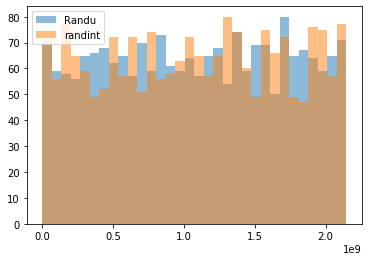

In [198]:
class Randu:
    """A python implementation of the IBM RANDU LNG.
    Never use this for anything non-trivial"""
    
    def __init__(self, seed=1):
        
        self._I = seed
        
    def __call__(self):
        self._I = (65539*self._I)%(2**31)
        return self._I
        
randu= Randu(1)
data = ['%011o'%randu() for _ in range(8)]
print(data)
randu= Randu(2)
data = ['%011x'%randu() for _ in range(8)]
print(data)
randu_data = [randu() for _ in range(2**11)]
random_data = [random.randint(0,2**31-1) for _ in range(2**11)]
p.hist(randu_data, 32, alpha=0.5, label='Randu')
p.hist(random_data, 32, alpha=0.5, label='randint')
p.legend();

This is obviously not a brilliant sequence (not least, for a given seed it is always either odd or even), but compared to `randint`, it appears to do a reasonale job in terms of probability density with wide bins. Unfortunately there a some deeper problems with `Randu`, which will revisit later.

### Continuous Probability

#### The Cumulative Distribution Function

Rather than a dice, giving integer, think about picking a real number, $x$, say between 0 and 4, with all numbers having equal chance. The probability of picking any particular number is effectively zero (since virtually every real number isn't that one. However, there should be a 50-50 chance that $x$ is less than 2 or greater than 2 (  i.e. $P(x\leq2)=0.5$ )and a $0.25$ chance that $x\leq 1$. Generalizing this, we can come up with a formula
$$ P(x<z)= \left\{\begin{array}{cc}
0& z<0,\\
\frac{z}{4}& z\leq 0<4,\\
1 & z\geq4.
\end{array}\right.
$$

This is the *cumulative distribution function* (CDF) of our continuous variable.

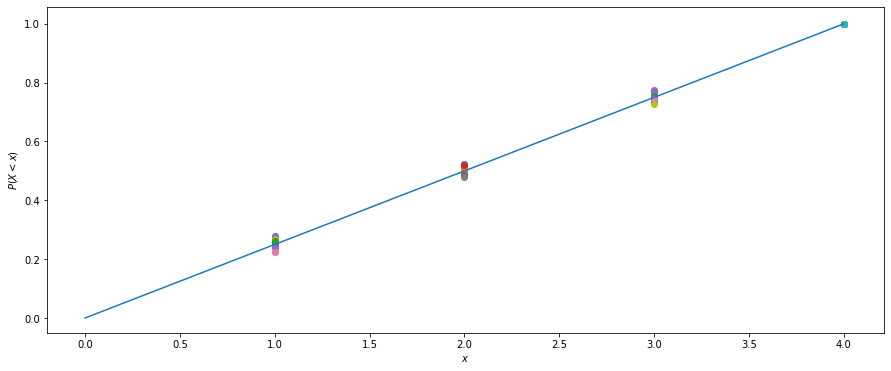

In [4]:
# Plot the CDF of a uniform distribution, along with some samples

p.figure(figsize=(15,6))

X = np.random.uniform(0,4,(20, 1000))

for x in X:
    for y in [1,2,3,4]:
        p.scatter(y,sum(x<y)/1000)
        
p.plot([0,4],[0,1])
p.xlabel('$x$')
p.ylabel('$P(X<x)$');

#### Probability densities

For sufficiently smooth probability distributions,we may write our CDF as an integral

$$P(X<z) = \int^z_{-\infty} p(x) dx $$ or in a (basically) equivalent form,

$$ p(x) = \frac{dP(X<z)}{dz}.$$

This $p(x)$ is the *probability density function* (PDF) of the distribution. Many well known probability distributions can be written this form, including the uniform distribution. 

[0, 4, 0, 1.0]

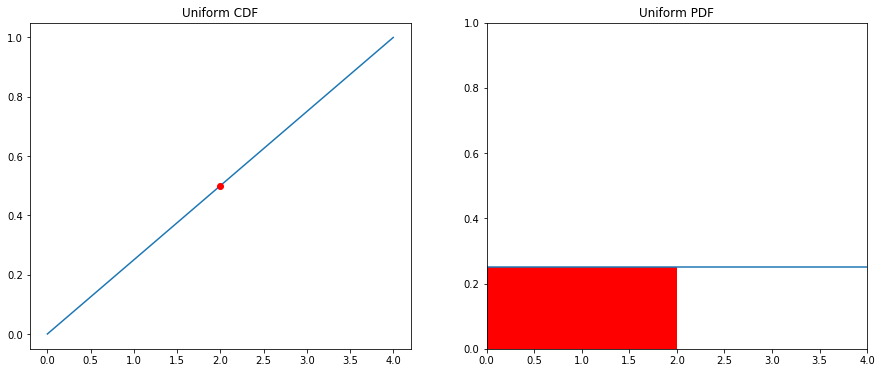

In [5]:
# Plot the CDF and PDF for the uniform distribution
p.figure(figsize=(15, 6))
# CDF
p.subplot2grid((1, 2), (0, 0))
p.plot([0, 4], [0, 1])
p.title('Uniform distribution CDF')
p.plot([2],[0.5], 'ro')
#PDF
p.subplot2grid((1, 2), (0, 1))
p.plot([0, 4], [0.25, 0.25])
p.title('Uniform distribution PDF')
p.fill_between([0,2], [0.25, 0.25], fc='r')
p.axis([0,4,0, 1.0])

#### The Gaussian or Normal Distribution

The Gaussian distribution (in many circumstances also called the "normal distribution") has a distribution function given as

$$ p(x) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left( - \frac{(x-\mu)^2}{2\sigma^2} \right) $$

This is the classic "bell-curve" or "hump" distribution, with the likelihood strongly (but smoothly) clumped around the mean $\mu$, decaying with a variance $sigma^2$ towards zero at $\pm\infty$.

[-4.0, 4.0, 0, 1]

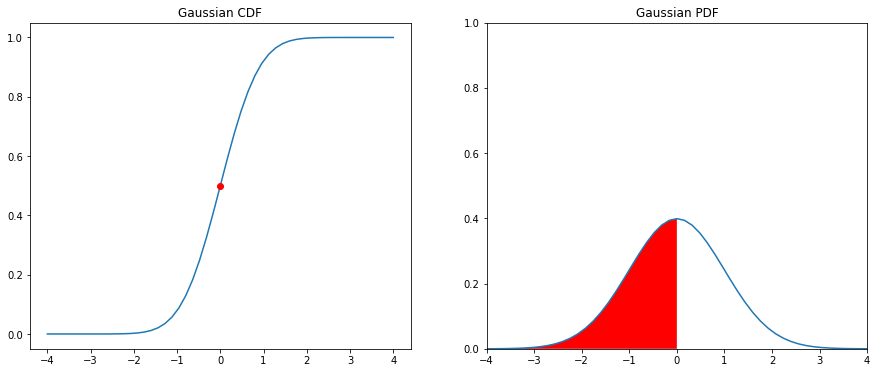

In [6]:
# Plot the CDF and PDF for the Gaussian distribution
from scipy.special import erf

p.figure(figsize=(15, 6))
# CDF
p.subplot2grid((1, 2), (0, 0))
x = np.linspace(-4,4, 51)
p.plot(x, 0.5*(1+erf(x)))
p.title('Gaussian CDF')
p.plot(0, 0.5*(1.0+erf(0)), 'ro')
#PDF

def p_x(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)

p.subplot2grid((1, 2), (0, 1))
p.plot(x, p_x(x))
p.title('Gaussian PDF')
p.fill_between(x[:26], p_x(x[:26]), fc='r')
p.axis([x.min(), x.max(), 0, 1])

Unusually, if $X$ is a Gaussian random variable, with mean $\mu_x$ and variance $\sigma_X^2$, and $Y$ is another independent Gaussian random variable, with mean $\mu_Y$ and variance $\sigma_Y^2$, then $Z=X+Y$ also follows a Gaussian distribution, with mean $\mu_X+\mu_Y$ and variance $\sigma_X^2 +\sigma_Y^2$. While the last two properties are not a total surprise (see the section above on the algebra of random variables), it is uncommon for a combination of variables from a given distribution to generate a variable from the same distribution.

For this reason, along with other similar ones, the normal distribution is often used as an approximation for real world data, especially when the uncertaintities are generated from multiple independent sourcces. This can be true even when the original uncertainties are discrete. For a coded example, we return to our dice:

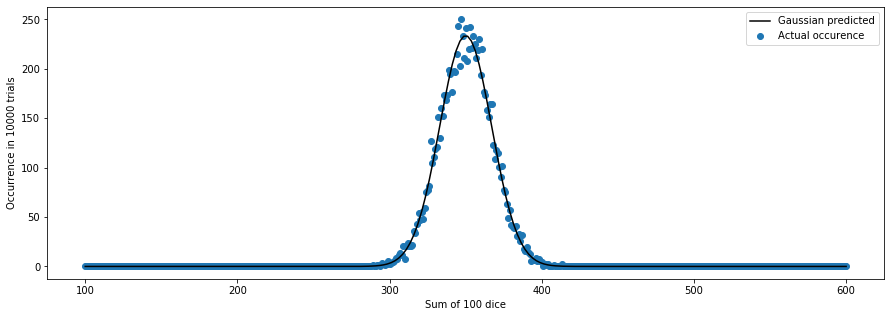

In [7]:
totals = np.zeros(501)

# we'll toss 100 dice 10000 times, summing the total each time

values = np.random.randint(0, 6, size=(10000, 100)) + 1

for v in values:
    totals[sum(v)-100] += 1
    

p.figure(figsize=(15,5))
p.scatter(range(100,601), totals, label='Actual occurence')

x = np.linspace(100, 600, 200)
p.plot(x, 10000/np.sqrt(2*np.pi*100*35/12)*np.exp(-(x-350)**2/(2*(100*35/12))), 'k', label='Gaussian predicted')
p.xlabel('Sum of 100 dice')
p.ylabel('Occurrence in 10000 trials')
p.legend();

#### The multivariate Gaussian distribution

Let's extend our world from a one dimensional continuous random variable, $X$,  to a two dimensional one, $ \mathbf{X} = {X, Y}$. Our Cumulative distribution function now becomes a joint probability, $F_\mathbf{X}=P(X\leq x, Y\leq y)$, where the comma should be taken as implying both the first statement *and* the second are true. Given a CDF, it's natural to look for a probability density function such that
$$ P(X\leq x, Y\leq y) = \int_{-\infty}^x \int_{-\infty}^y p_{\mathbf{X}}(x',y') dy\,dx, $$
or equivalently
$$ p_{\mathbf{X}} = \frac{\partial^2 F_\mathbf{X}}{\partial x\partial y}.$$
If the variables $X$ and $Y$ are **independent** and have probability density functions $p_X(x)$ and $p_Y(y)$, we can write

$$\begin{eqnarray*}
P(X\leq x, Y \leq y) &= P(X\leq x) P(Y\leq y),\\
&=\int^x p_X(x') dx' \int^y p_Y(y') dy',
&=\int_{-\infty}^x \int_{-\infty}^y p_X(x')p_Y(y') dy\,dx.
\end{eqnarray*}
$$

Hence for independent variables $p_{\mathbf{X}}(x,y) = p_x(x)p_y(y)$. When the variables are correlated this usually becomes more difficult. However, for Gaussian distributions we know that we have an advantage. Sums of Gaussian distributions are still Gaussian, so we can look for a comination of the $\mathbf{X}$ which happens to be independent. Define the covariance matrix of $\mathbf{X}$,

$$\mathbf{M}_\mathbf{X}:= E([\mathbf{X}-E(\mathbf{X}][\mathbf{X}-E(\mathbf{X})]) = \left(\begin{array}{cc}
\mbox{var}(X)& \mbox{cov}(X,Y)\\
\mbox{cov}(Y,X)& \mbox{var}(Y)
\end{array}
\right)
$$

we seek a matrix $\mathbf{L}$ defining a transformation, $\mathbf{Z}=\mathbf{L}\mathbf{X}$ such that the covariance matrix of $\mathbf{Z}$ is diagonal. Substituting into the definition above we find $\mathbf{M}_\mathbf{Z} = \mathbf{L}\mathbf{M}_\mathbf{X}\mathbf{L}^T$. Since $\mathbf{M}_\mathbf{X}$ is a symmetric real matrix we should know a diagonal decomposition $\mathbf{M} = \mathbf{V}\mathbf{D}\mathbf{V}^T$, where $\mathbf{V}$ is orthonormal (i.e. $\mathbf{V}^T = \mathbf{V}^T$). So we can pick $\mathbf{L} = \mathbf{V}^T$ and we are done. As a bonus the transformation has determinant equal to 1, so we don't need to fiddle with the integral and can write

$$p_\mathbf{Z}(\mathbf{z}) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_{i}^2}}\exp\left(-\frac{(z_i-\mu_i)^2}{\sigma_i^2}\right)=\frac{1}{\sqrt{(2\pi)^n\det(\mathbf{D})}}\exp\left(\frac{(\mathbf{z}-\mathbf{\mu}_\mathbf{z})^T\mathbf{D}^{-1}(\mathbf{z}-\mathbf{\mu}_\mathbf{z})}{2}\right).$$

Substituting back into $x$ variables we get the final form,

$$p_\mathbf{X}(\mathbf{x}) = \frac{1}{\sqrt{(2\pi)^n\mbox{\det(\mathbf{M}_{\mathbf{X}}}}} \exp\left(-\frac{(\mathbf{x}-\mathbf{\mu})^T\mathbf{M}_\mathbf{X}^{-1](\mathbf{x}-\mathbf{\mu})}{2}\right).$$

### Bayes theorem

In general, given two random variables the probability of the event $A$ and $B$ (sometimes also written $P(A\cap B)$ can be thought of in two ways:
1. B happens, and given B happened, A also happens.
2. A. happens and given A happend, B also happens.

The probability of the new event "given B happened, A happened", written $P(A \vert B)$ is independent of the probability $B$ (since B has already happened), so using the formula for independent events

$$ P(A\cap B) = P(A\vert B) P(B).$$

Similarly, calculating things the other way round we have

$$ P(A\cap B) = P(B\vert A) P(A).$$

For those who like graphical proofs, the area of the green segment,($A\cap B$) is equal to the area of the blue circle ($P(B)$),times the ratio of the green segment to the blue circle ($P(A\vert B)$), and similarly for the yellow circle.

Putting this together, and assuming that $P(A) \neq 0$, we get Bayes' Theorem,

$$\tag{Bayes' Theorem} P(B \vert A) = \frac{ P(A \vert B) P(B) }{P(A)}. $$ 

We will return to this identity later in the lecture.


### The log-normal distribution

Another common distirbution related to the Gaussian distribution is the *log-normal* distribution. This is a two parameter distribution generating numbers the range $(0,\infty)$ where the natutal logarithm of the variable, $\log(X)$ or $\ln X$, is normally distibuted. The parameters for the model are usual taken as the mean, $\mu$, and standard deviation, $\sigma$, of the normal distribution of the logarithms. The propability density function is
$$ p(x) = \frac{1}{x\sigma\sqrt{2\pi}}\exp\left(-\frac{[\log(x)-\mu]^2}{2\sigma^2}\right),$$

and the cumulative distribution function is

$$ \frac{1}{2}\left[1+\mbox{erf}\left(\frac{\log x - \mu}{\sigma\sqrt{2}}\right)\right]. $$

[0.01, 4.0, 0, 1]

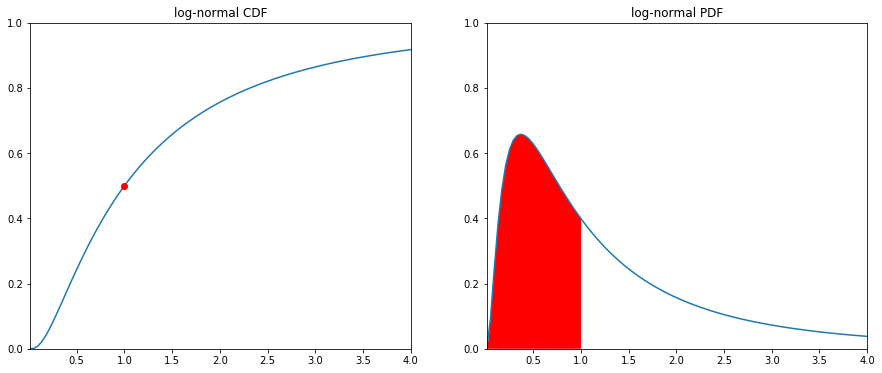

In [8]:
# Plot the CDF and PDF for the Gaussian distribution
from scipy.special import erf

p.figure(figsize=(15, 6))
# CDF
p.subplot2grid((1, 2), (0, 0))
x = np.linspace(0.01,4, 101)
p.plot(x, 0.5*(1+erf(np.log(x)/np.sqrt(2))))
p.title('log-normal CDF')
p.plot(1, 0.5*(1.0+erf(0)), 'ro')
p.axis([x.min(), x.max(), 0, 1])
#PDF

def p_x(x):
    return 1/x/np.sqrt(2*np.pi)*np.exp(-np.log(x)**2/2)

p.subplot2grid((1, 2), (0, 1))
p.plot(x, p_x(x))
p.title('log-normal PDF')
p.fill_between(np.linspace(0.01,1), p_x(np.linspace(0.01,1)), fc='r')
p.axis([x.min(), x.max(), 0, 1])


Due to one of the laws of logarithms,

$$ \log(ab) = \log(a)+\log(b), $$
the product of log-normal distributions is log-normally distributed and the distribution can approximate the limit of products of other distritions, just as Gaussians predict their sum.

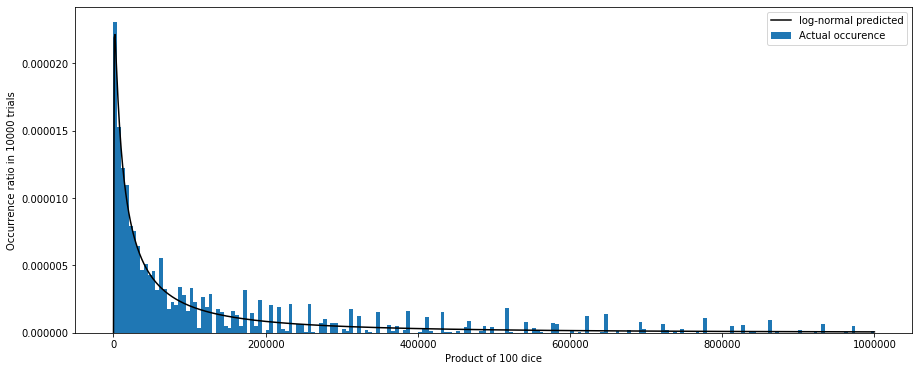

In [9]:
# we'll toss 10 dice 10000 times, taking the product of the totals each time


totals = []
values = np.random.randint(0, 6, size=(10000, 10)) + 1

for v in values:
    prod = 1
    for _ in v:
        prod *= _
    totals.append(prod)


# plot a histogram of the 
p.figure(figsize=(15,6))
p.hist(totals, bins=200, range=(0, 1e6), density=True, label='Actual occurence')

x = np.linspace(0.1, 1e6, 1000)
p.plot(x, 1/x/np.sqrt(2*np.pi*3.65)*np.exp(-(np.log(x)-10.9654)**2/(2*(3.65))), 'k', label='log-normal predicted')
p.xlabel('Product of 100 dice')
p.ylabel('Occurrence ratio in 10000 trials')
p.legend();

#### Continuous expectations

The expectation formula for a continuous random variable, $X$, replaces the sum over possible discrete values with an integral over the range of possible continuous value and weighting by the event probability with weighting with the event PDF,

$$ E(X) = \int_{-\infty}^{\infty} x p(X=x) dx. $$
Similarly the variance is now

$$ E(X^2)-E(X)^2 =  \int_{-\infty}^{\infty} x^2 p(X=x) dx - \left( \int_{-\infty}^{\infty} x p(X=x) dx \right)^2 $$


### Stochastic computation
#### Getting samples for the continuous uniform distribution

Virtually all modern programming languages at least provide a method of obtaining samples of (distretizations of) the uniform distribution over $[0,1]$. Sometimes the implementation is something as simple as the following (usually replacing RANDU with a better behaved integral random number generator of course).

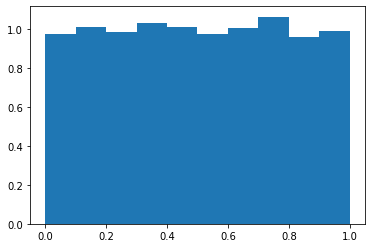

In [10]:
class RealRandu(Randu):
    """Real uniform random number generator based on RANDU."""

    def __call__(self):
        super().__call__();
        return self._I/(2**31)
    
randr = RealRandu()
data = [randr() for _ in range(9999)]
p.hist(data, density=True);
    

Text(0.5, 0, 'z')

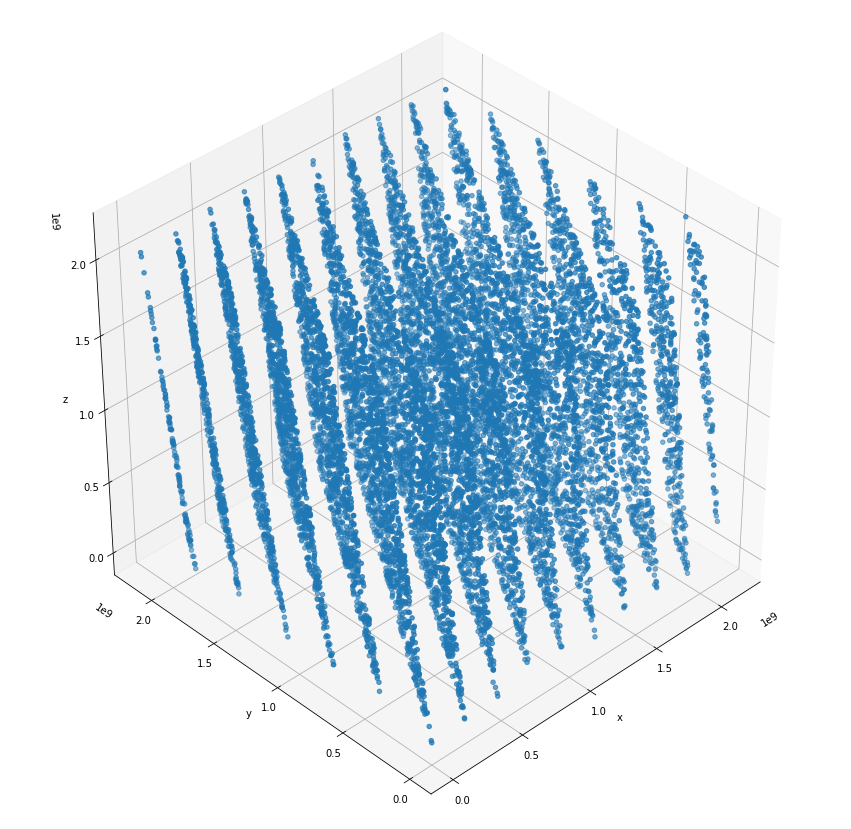

In [11]:
from mpl_toolkits.mplot3d import Axes3D
rand = Randu(1)
data = [rand() for _ in range(39999)]

data = np.array(data).reshape((len(data)//3, 3)).T

fig = p.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*data)

ax.azim = -134
ax.elev =38
ax.xaxis.set_label_text('x')
ax.yaxis.set_label_text('y')
ax.zaxis.set_label_text('z')

While robust and easy to implement, this approach can interact badly with floating point arithmatic under some circumstances.

#### The Box Mueller transformation

To return to an earlier point, for an arbitrary function of random variables, the input distribution doesn't have to be directly related to the output distribution. As a mild example, we can generate two numbers drawn from the Gaussian distribution from two numbers, $a$ & $b$, drawn from the uniform distribution on $[0, 1]$, using Box-Muller transformation,
$$ n_1 \sym \mathcal{N}(0, 1) = \sqrt{-2\log a) \sin(b), \quad
n_2 \sym \mathcal{N}(0, 1) = \sqrt{-2\log a) \cos(b). $$

This (and other similar tricks) can be useful in programming languages (such as C, though not  C++) which only provide uniform random variables in standard libraries. Watch out that some transformations are known to expose bad behaviour in pseudorandom number generators.

AttributeError: module 'matplotlib.pyplot' has no attribute 'linspace'

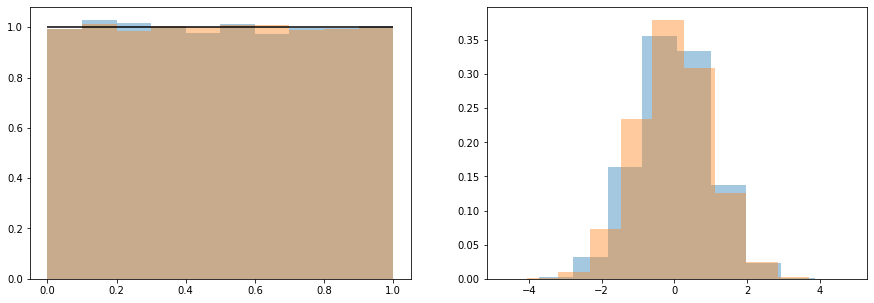

In [12]:
# A python demonstration of the Box-Muller algorithm

def box_muller(a, b):
    r = np.sqrt(-2*np.log(a))
    theta = 2*np.pi*b
    return r*np.sin(theta), r*np.cos(theta)


N = 100000
a = np.random.uniform(size=N)
b = np.random.uniform(size=N)

p.figure(figsize=(15,5))

p.subplot2grid((1, 2), (0, 0))
p.hist(a, density=True, alpha=0.4)
p.hist(b, density=True, alpha=0.4)
p.hlines(1.0, 0.0, 1.0)

n1, n2 = box_muller(a, b)

p.subplot2grid((1, 2), (0, 1))
p.hist(n1, density=True, alpha=0.4)
p.hist(n2, density=True, alpha=0.4)
x = p.linspace(-4, 4)
def p_x(x):
    return 1/p.sqrt(2*p.pi)*p.exp(-x**2/2)
p.plot(x, p_x(x));

## Statistical Interpolation

### Finding the time when you have two clocks

Consider a hypothetical problem where you wish to know the time and happen to be able to see two clocks. If these agree then there is no difficulty, but what if they disagree? Obviously a good guess will sit somewhere in between the times on the clocks. If you happen to know that one clock is more accurate, then your guess should probably be closer to the time shown on that clock, but how much closer?

Let's start trying to model this mathematically. We will call the real time $T_\mbox{true}$, and the times on the two clocks as $T_1$ and $T_2$. We will also define the errors $\epsilon_1$ and $\epsilon_2$,

$$\epsilon_1 = T_1 -  T_\mbox{true},$$
$$\epsilon_2 = T_2 -  T_\mbox{true}.$$

We will seek the Best Linear Unbiased Estimator (BLUE) for $T$, that is we seek a value which is 

1. A linear combination of the data
2. Unbiased (i.e its expected value is the true one)
3. Optimal (in the sense of minimizing its mean square error

Since our guess, $T_{guess}$ is to be a linear combination of the two times, we may write it as

$$T_{\mbox{guess}} = a T_1 +b T_2$$
For some parameters, $a$ and $b$. This guess has its own error
$$\epsilon_{\mbox{guess} = T_\mbox{guess} -T_\mbox{true}..$$  

We can view the various times, $T_1$, $T_2$ and $T_\mbox{guess}$ and their errors as random variables. Let's get some naive statistics. First the expected value of $T_\mbox{guess}$,

$$\begin{eqnarray*}
\epsilon_\mbox{guess} & (a+b-1)T_\mbox{true} + a\epsilon_1 +b\epsilon_2,\\
& = (a+b-1)T_\mbox{true} +aE(\epsilon_1)+bE(\epsilon_2).
\end{eqnarray*}
$$

We desire that $E(T_{\mbox{guess}})=T_\mbox{true}$, i.e. that $E(\epsilon_\mbox{guess})=0$. As for its variance,

$$  E(\epsilon_\mbox{guess}^2) = E \left([a\epsilon_1+b\epsilon_2]^2\right)$$

This is also the mean square error for the system. If the clock errors are known to be unbiased themselves, the desire for an unbiased estimator implies that $b= 1-a$. Substituting this into the variance formula, we now have a function of the parameter $a$,

$$f(a) := E(\epsilon_\mbox{guess}^2) = a^2\sigma^2_1 + (1-a)^2 \sigma^2_2.$$

Using knowledge from previous lectures we can minimise this by find a value of $a$ such that $f'(a)=0$, i.e

$$ 2a \sigma^2_1 -2(1-a)\sigma^2_2 =0,$$
or $a= \frac{\sigma^2_2}{\sigma^2_1+\sigma^2_2}$

All this implies that our best guess is

$$ T_\mbox{guess} = \frac{\sigma^2_2 T_1+\sigma_1^2 T_2}{\sigma^2_1+\sigma^2_2} $$

with a mean square error

$$ E(\epsilon_{\mbox{guess}}^2)=\frac{\sigma^2_1 \sigma^2_2}{\sigma^2_1+\sigma^2_2}. $$

Lets run some code for a concrete example.

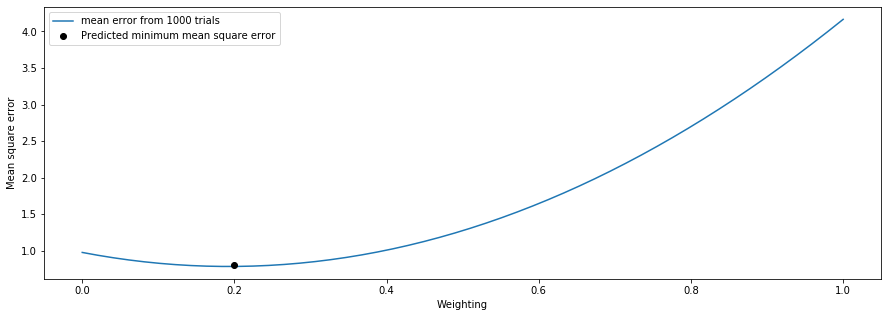

In [151]:
# We'll make the truth the zero state

T_true = 0.0


# Generate some vectors of examples

T_1 = T_true + np.random.normal(0, scale=2, size=1000)
T_2 = T_true + np.random.uniform(-np.sqrt(3),np.sqrt(3), size=1000)

def T_guess(a):
    """Function to generate zero bias """
    return a*T_1+(1-a)*T_2

x=np.linspace(0,1)
error = [np.mean((T_guess(_)-T_true)**2) for _ in x]

p.figure(figsize=(15,5))
p.plot(x, error, label='mean error from 1000 trials')

p.plot(1**2/(1**2+2**2),(1**2*2**2)/(1**2+2**2),'ko', label='Predicted minimum mean square error');
p.xlabel('Weighting')
p.ylabel('Mean square error')
p.legend();

#### Exercises

 - Prove that the value found is indeed a minimum, rather than a maximum
 - Try to extend the analysis to three clocks, then generalize it for $n$. You can do this either using substitution (as above), or by using a Lagrange multiplier for the constraint $E(\epsilon_\mbox{guess})=0$ (i.e. $a+b+\ldots=1).
 - The BLUE is the best linear unbiased estimator. Can you find a better biased estimator?

### The optimal interpolation method


In the last case we only had observations, but often we have an existing full set of data, $\mathbf{x}_b$, referred to as the *background*, along with a limited set of observations, $\mathbf{y}$, which we wish to use to improve it. In NWP (or more generally when solving a mathematical model), $\mathbf{x}_b$ will be all the variables used to make a forecast (also known as the *prognostic* variables), written as a single one dimensional vector (or array). This vector will be of some fixed length, $m$. Meanwhile the relevant observations are all written as another one dimensional vector of length $n$.

Thus far, we have made no kind of assumption about what the information stored in $\mathbf{x}$ (nor in $\mathbf{y}$) represents. They could be grid point values in a finite difference model, volume values in a finite volume model or coefficent parameters in a finite element or spectral model. They could even be long term mean values derived from statistical records. All that matters is that they are continuous valued and that for field data, there has been some kind of discretization made so that there are a finite number of elements in the two vectors.

### The observation operator

Since the observations are related to the prognostic model variables, we will assume that there is some kind of mapping or observation operator, $H$ taking a given true state $\mathbf{x}$ and returning the observed value one would expect to see. For now we will also guess that the mapping is linear, so that it can be represented as a matrix.

As a concrete example, let the $\mathbf{x}_b$ be the surface temperatures at 4 corners of a grid square, and let the $mathbf{y}$ be two temperature measurements within it. Then assuming a bilinear interpolation

$$ y_i = \sum_{j=1}^4 \alpha(r_i, s_i)_j[\mathbf{x}_b]_j $$

and 
$$ \mathbf{H} = \left(
\begin{array}{cccc}
\alpha(r_1, s_1)_1&\alpha(r_1, s_1)_2& \alpha(r_1, s_1)_3&\alpha(r_1, s_1)_3\\
\alpha(r_2, s_2)_1&\alpha(r_2, s_2)_2& \alpha(r_2, s_2)_3&\alpha(r_2, s_2)_3
\end{array} \right).$$


Note that $\mathbf{H}$ is a $m\times n$ matrix and so not generally square.

Given our backgorund, our observations and the observation matrix $\mathbf{H}$ we can define an *innovation* vector, $mathbf{z}$ representing "new" knowledge,

$$\mathbf{z} = \mathbf{y} - \mathbf{H}\mathbf{x}_b.$$

This is another length $n$ vector telling us whether our observations were higher or lower than we would have expected them to be, given our previous forecast.

As when considering the clocks, we will make a new guess at the current state of the system, $\mathbf{x}_a$, now called an analysis, and we will assume that the new information brought in is represented by some linear combination of our innovation vector

$$\mathbf{x}_a = \mathbf{x}_b + \mathbf{W}\mathbf{z}. $$ 

At this point we will introduce a hypothetical *true* state, $\mathbf{x}_t$, as well as the (fixed) background and observation errors and the analysis error, which is a function of the weight matrix, $\mathbf{W}$,

$$\mathbf{\epsilon}_b = \mathbf{x}_b-\mathbf{x}_t, $$
$$\mathbf{\epsilon}_o = \mathbf{y}-\mathbf{H}\mathbf{x}_t, $$
$$\mathbf{\epsilon}_a = \mathbf{x}_a-\mathbf{x}_t = \mathbf{\epsilon_b}+\mathbf{W}(\mathbf{\epsilon}_o-\mathbf{H}\mathbf{\epsilon}_b). $$

In a similar manner to the clocks problem we will seek to minimise the sum of the component variances of the analysis error,

$$ f(\mathbf{W}):=E(\mathbf{\epsilon}_a^T \mathbf{\epsilon}_a) - \|E(\mathbf{\epsilon}_a)\|^2 
=  E([[\mathbf{\epsilon_b}+\mathbf{W}(\mathbf{\epsilon}_o-\mathbf{H}\mathbf{\epsilon}_b)])-\|E([\mathbf{\epsilon_b})+\mathbf{W}(E(\mathbf{\epsilon}_o)-\mathbf{H}E(\mathbf{\epsilon}_b))]\mathbf{\epsilon_b}+\mathbf{W}(\mathbf{\epsilon}_o-\mathbf{H}\mathbf{\epsilon}_b)]^T)\|^2.$$

Assuming that the background and observation errors have zero mean (so that in turn $E(\mathbf{\epsilon}_a)=0$) and taking derivatives with respect to the $\mathbf{W}$ we get a normal equation

$$ 2E((\mathbf{\epsilon}_o-\mathbf{H}\mathbf{\epsilon}_b)^T[\mathbf{\epsilon_b}+\mathbf{W}(\mathbf{\epsilon}_o-\mathbf{H}\mathbf{\epsilon}_b)])= 0.$$

taking the further assumption that the observation and background errors are uncorrelated (so that $E(\mathbf{H}\mathbf{\epsilon}_b\mathbf{\epsilon}_o^T)=0$ and introducing the notation

$$ \mathbf{B}:= E(\mathbf{\epsilon}_b\mathbf{\epsilon}_b^T),$$
$$ \mathbf{R}:= E(\mathbf{\epsilon}_o\mathbf{\epsilon}_o^T),$$
for the background and observation error covariances (size $m\times m$ and $n \times n$ respectively),
we can see (eventually) that the optimal weight matrix satisfies


$$\mathbf{W}_{\mbox{optimal}} := \mathbf{B} \mathbf{H}^T\left( \mathbf{R} + \mathbf{H}\mathbf{B}\mathbf{H}^T\right)^{-1}.$$

Note that the matrix to be inverted is of size $n \times n $, which will usually be significantly smaller that the $\mathbf{B}$ matrix. This is a good thing in terms of computational efficiency.

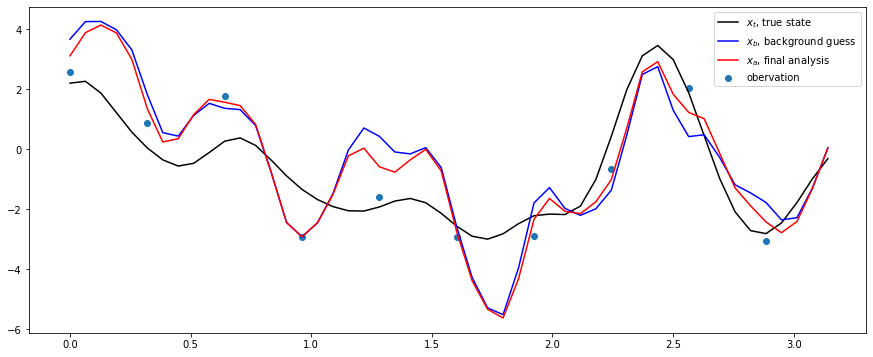

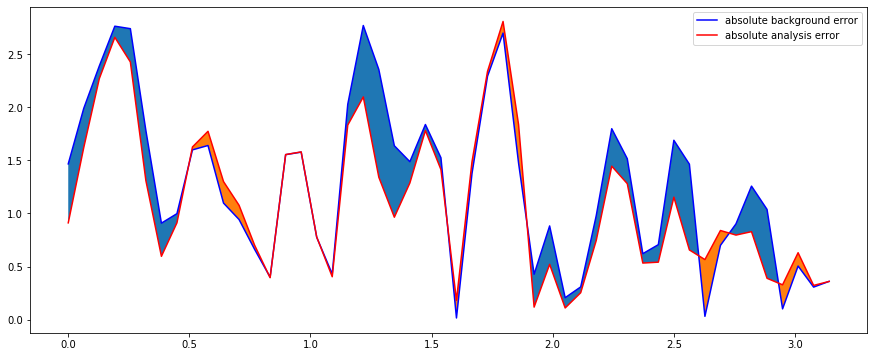

In [32]:
### Example optimal interpolation implementation & solution

### we will use 1d data and errors from a known distribution


### since the problem is small, we'll actually calculate full inverses
### generally this is a bad idea, and alternatives such as
### iterative methods should be considered
from scipy.linalg import inv


### define the standard deviation of the background and observations

sigma_t = 1.0
sigma_b = 1.0
sigma_r = 1.0

l_t = 0.2
l_e = 0.1
l_b = l_e

s = np.linspace(0, np.pi)

e_b = np.zeros(len(s))
x_t = np.zeros(len(s))

for _ in range(len(s)):
    e_b += np.random.normal(0, sigma_b)*np.exp(-(s-s[_])**2/l_e**2)
    x_t += np.random.normal(0, sigma_t)*np.exp(-(s-s[_])**2/l_t**2)

x_b = x_t + e_b



H = np.zeros((len(s)//5, len(s)))
for _ in range(H.shape[0]):
    H[_,5*_] = 1
    
y = np.dot(H, x_t) 
y += np.random.normal(0, 1, size=(y.shape))


R = sigma_r**2*np.eye(y.shape[0])

s2 = np.broadcast_to(s, (len(s), len(s)))
B = sigma_b**2*np.exp(-(s2-s2.T)**2/l_b**2)

W = B.dot((H.T)).dot(inv(R+H.dot(B.dot(H.T))))

x_a = x_b + W.dot(y-H.dot(x_b))

p.figure(figsize=(15, 6))
p.plot(s, x_t, 'k', label='$x_t$, true state')
p.plot(s, x_b, 'b', label='$x_b$, background guess')
p.scatter(s[::5], y, label='obervation')
p.plot(s, x_a, 'r', label='$x_a$, final analysis')
p.legend()

p.figure(figsize=(15, 6))
p.plot(s, abs(x_b-x_t), 'b', label='absolute background error')
p.plot(s, abs(x_a-x_t), 'r', label='absolute analysis error')
p.fill_between(s, abs(x_b-x_t), abs(x_a-x_t), where=abs(x_b-x_t)>abs(x_a-x_t), interpolate=True)
p.fill_between(s, abs(x_b-x_t), abs(x_a-x_t), where=abs(x_b-x_t)<abs(x_a-x_t), interpolate=True)
p.legend();


We can also define the analysis error covariance matrix

$$ \mathbf{P}: = E(\mathbf{\mathbf{\epsilon}_a\mathbf{\epsilon}_a^T) = mathbf{B}-\mathbf{B}\mathbf{H}^T\mathbf{W}-\mathbf{W}^T\mathbf{H}\mathbf{B}+\mathbf{W}(\mathbf{R}+\mathbf{H}\mathbf{B}\mathbf{H}^T\mathbf{W}^T,$$

so that for the optimal choice the _analysis_ error covariance matrix is

$$\mathbf{P} = (\mathbf{I}-\mathbf{B}\mathbf{H}^T(\mathbf{R}+\mathbf{H}\mathbf{B}\mathbf{H}^T)^{-1}\mathbf{H})\mathbf{B}.$$

#### Exercises

 - Experiment with the example OI code given above:
    1. Try adding some systematic biases to the observations. How large must these be before the mean square error of the analysis regularly exceeds that of the background?
    2.
 
 

## The variational approach,  3D-Var

### Nonlinear observation operators

While interpolation operators are frequently linear, and thus well represented in matrix form, not all measurements are direct functions of the state variables of the model. A more general representation defines a (potentially) nonlinear *observation operator* as a function mapping the state variable values into the observation space. As a concrete example, simple anemometers measure wind speed, but not direction. Here the o  perator is

$$ h(u,v) = \sqrt(u^2 + v^2) $$

We can also define our new observation errror,
$$\mathbf{\epsilon}_o := \mathbf{y} - \mathbf{h}(\mathbf{x}_t)$$
and the linearization of $\mathbf{h}$,
$$H_{ij} := \frac{\partial h_i}{\partial x_j}$$

### Bayesian inference

Recall from our probability recap that

$$ \tag{Bayes' theorem} P(x\vert y) = \frac{P(y\vert x) P(x)}{P(y)}.$$

If probabilities are viewed as measures of belief then this allows us to update our $posterior$ estimate of the likelihood of an event based on new information observed and our $prior$ belief of its probability. If we assume that all errors are Gaussian multivariate variables with known error covariances, then we can calculate the *a posteriori* probability density of a state $\mathbf{x}$ given observations $\mathbf{y}$ (i.e. $p(\mathbf{x}\vert \mathbf{y})$) using the density form of Bayes theorem,

$$ p(\mathbf{x}\vert \mathbf{y}) = \frac{p(\mathbf{y}\vert \mathbf{x}) p(\mathbf{x})}{p(\mathbf{y})}.$$

Here the forms of the functions of $\mathbf{x}$ in the numerator,
$$ p(\mathbf{x})= \frac{1}{\sqrt{2^m}\vert\mathbf{B}\vert}\exp\left(\frac{(\mathbf{x}_b-\mathbf{x})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x})}{2}\right),$$
$$ p(\mathbf{y}\vert\mathbf{x})= \frac{1}{\sqrt{2^n}\vert\mathbf{R}\vert}\exp\left(\frac{(\mathbf{y}-h(\mathbf{x}))^T\mathbf{R}^{-1}(\mathbf{y}-h(\mathbf{x}))}{2}\right),$$

both follow from the assumptions that the background and observation errors are multivariate Gaussian diestribution. There is no such obvious definition of $p(\mathbf{y})$, however since we are seeking an optimal $\mathbf{x}$, it is sufficient to maximize

$$ \exp\left(-\frac{(\mathbf{x}_b-\mathbf{x})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x})+(\mathbf{y}-h(\mathbf{x}))^T\mathbf{R}^{-1}(\mathbf{y}-h(\mathbf{x}))}{2}\right),$$

which is equivalent to minimizing

$$\mathcal{J}(\mathbf{x}) = (\mathbf{x}_b-\mathbf{x})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x})+(\mathbf{y}-h(\mathbf{x}))^T\mathbf{R}^{-1}(\mathbf{y}-h(\mathbf{x})) $$

as a function of $\mathbf{x}$.

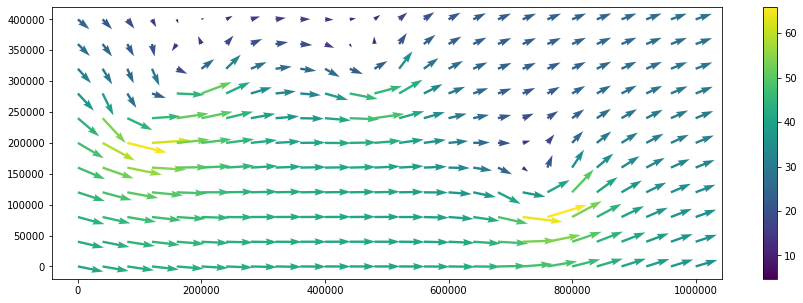

In [199]:
# example 3D-Var implementation and solution

# will probably use some pseudo-weather-like 2d data and generate B from statistics.

nx = 26
ny = 11

Lx = 1e6
Ly = 4e5

U_0 =  30.0
radius = 5e4

def wind_field(X, Y, circulations, centres):
    
    U = np.full((ny, nx), U_0)
    V = np.zeros((ny, nx))
    
    for circ, (x, y) in zip(circulations, centres):
        
        r2= (X-x)**2 + (Y-y)**2
        
        u = circ/(2*np.pi)*np.where(r2>radius**2, 1./r2, 1.0/radius**2) 
        
        
        U -= (Y-y)*u
        V += (X-x)*u
        
    return U, V

X, Y = np.meshgrid(np.linspace(0,Lx,nx), np.linspace(0,Ly, ny))


def random_vortices(N, kx=5, ky=5):
    return (200*np.random.lognormal(0, 0.1, size=N)*radius,
            np.random.uniform([-kx*radius, -kx*radius], [Lx+ky*radius, Ly+ky*radius], (N, 2)))

def plot_wind(X, Y, u, v):
    p.figure(figsize=(15,5))
    p.quiver(X, Y, u, v, np.sqrt(u**2+v**2))
    p.colorbar()
    p.axis('equal')
    
    
U_t, V_t = wind_field(X, Y, *random_vortices(4, -1, -1))
plot_wind(X, Y, U_t, V_t);

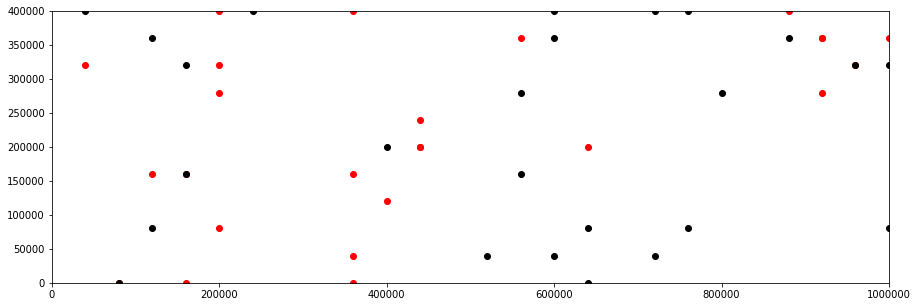

In [200]:
# observation locations
n_full = 25
n_speed = 25
y_loc = np.random.randint(0, nx*ny, n_full+n_speed)
# observation values
y = np.empty(2*n_full+n_speed)
y[:n_full] = U_t.ravel()[y_loc[:n_full]] + np.random.normal(0, 2.0, n_full)
y[n_full:2*n_full] = V_t.ravel()[y_loc[:n_full]] + np.random.normal(0, 2.0, n_full)
y[2*n_full:] = (np.sqrt(U_t.ravel()[y_loc[n_full:]]**2
                      + V_t.ravel()[y_loc[n_full:]]**2)
                      + np.random.normal(0, 2, n_speed))

def h(x):
    hx = np.empty(2*n_full+n_speed)
    u = x[y_loc]
    v = x[ny*nx+y_loc]
    hx[:n_full] = u[:n_full] = u[:n_full]
    hx[n_full:2*n_full] = v[:n_full]
    hx[2*n_full:] = np.sqrt(u[n_full:]**2+v[n_full:]**2)
    
    return hx

R = 2.0**2*np.eye(2*n_full+n_speed)

p.figure(figsize=(15,5))
p.scatter(X.ravel()[y_loc[:n_full]], Y.ravel()[y_loc[:n_full]], c='r')
p.scatter(X.ravel()[y_loc[n_full:]], Y.ravel()[y_loc[n_full:]], c='k')
p.axis([0, Lx, 0, Ly]);

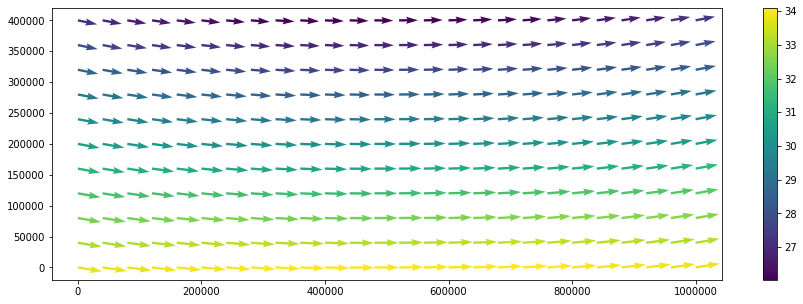

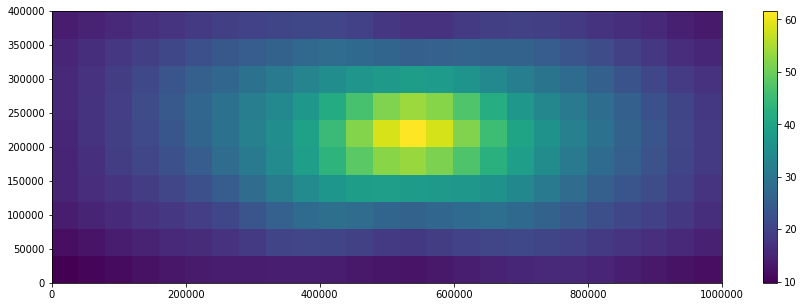

In [201]:
U = np.empty((5000,ny,nx))
V = np.empty((5000,ny,nx))

for _ in range(U.shape[0]):
    U[_, : :], V[_, :, :] = wind_field(X, Y, *random_vortices(4))

mu_u = np.mean(U, 0)
mu_v = np.mean(V, 0)

plot_wind(X, Y, mu_u, mu_v)

d = np.empty((U.shape[0], 2*ny*nx))

for _ in range(d.shape[0]):
    d[_, :ny*nx] = (U[_, :]-mu_u).ravel() 
    d[_, ny*nx:] = (V[_, :]-mu_v).ravel()
    
B = np.empty((2*nx*ny, 2*nx*ny))

for i in range(2*nx*ny):
    for j in range(2*nx*ny):
        B[i, j] = np.mean(d[:, i]*d[:, j])
    

p.figure(figsize=(15,5))
p.pcolormesh(X, Y, B[ny//2*nx+nx//2, :ny*nx].reshape((ny,nx)))
p.colorbar();

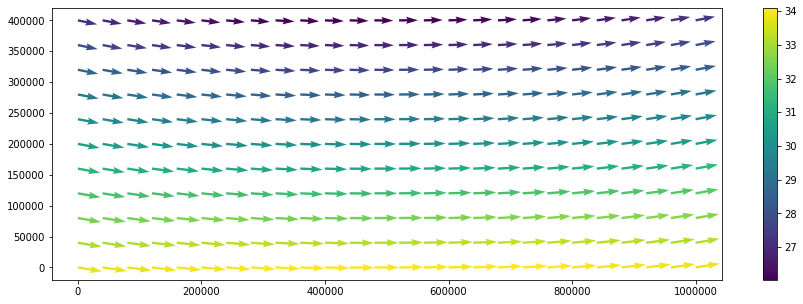

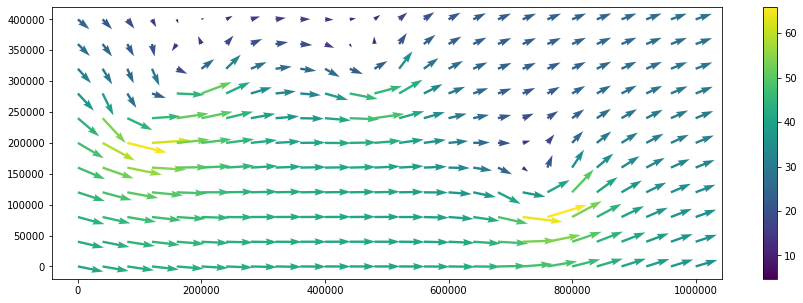

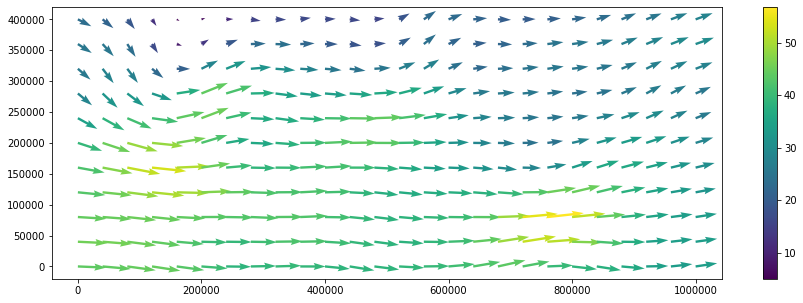

In [202]:
x_b = np.empty(2*ny*nx)

x_b[:ny*nx] = mu_u.ravel()
x_b[ny*nx:] = mu_v.ravel()

Binv = inv(B)
Rinv = inv(R)

def J(x):
    dx_b = x-x_b
    dx_o = y - h(x)
    return np.dot(dx_b, Binv.dot(dx_b))+np.dot(dx_o,Rinv.dot(dx_o))

def callback(x):
    if False:
        print(J(x))

from scipy.optimize import minimize

res = minimize(J, x_b, method='CG', callback = callback, tol = 1e-3, options={'maxiter':100})
x_a = res.x

U_a = x_a[:ny*nx].reshape((ny,nx))
V_a = x_a[ny*nx:].reshape((ny,nx))

plot_wind(X, Y, mu_u, mu_v)
plot_wind(X, Y, U_t, V_t)
plot_wind(X, Y, U_a, V_a)


If $h$ happens to be linear, the optimal solution which has $\nabla_\mathbf{x}\mathcal{J}=0$ satisfies

$$ \mathbf{B}^{-1}(\mathbf{\mathbf{x}_a-\mathbf{x}_b}) - \mathbf{H}^T\mathbf{R}^{-1}(\mathbf{y}-\mathbf{H}\mathbf{x}_a)=0$$

or 

$$ \mathbf{x}_a-\mathbf{x}_b = \left(\mathbf{B}^{-1}+\mathbf{H}^T\mathbf{R}^{-1}\mathbf{H}\right)^{-1}\mathbf{H}^T\mathbf{R}^{-1}[\mathbf{y}-\mathbf{H}\mathbf{x}_b] $$.

Unlikely as is may seem, this is actually the same solution as for the optimal interpolation method given above (this is a lot more trivial to prove when $\mathbf{H}$ is the identity operator).

#### Exercises

 - Try adding more observations, or some observations of the wind direction as well as speed. Which makes more difference to the analysis accuracy?
 - Can you rewrite the cost function in the example to use an iterative method to calculate $\mathbf{B}^{-1}(\mathbf{x}-\mathbf{x}_b)$ and $\mathbf{R}^{-1}(\mathbf{y}-\mathbf{h}(\mathbf{x}_b))$? Compare the time and memory requirements with the direct method for a few problem sizes.
 - Experiment with minimization methods; Can you provide a Jacobian to speed things up?

## The Kalman Filter

### Timestepping & information propagation

So far, we have ignored the concept of time, and have assumed that all observations are valid simultaneously. In the real world, at least on the time scales on which the weather is observed and forecast, this is not usually true. One option would be to apply a "stop-start" algorithm, run our forecast model forward and then apply our existing methods from the previous section. However we can do better by remembering that some statistical information propagates forward through the model almost as easily as the state does.

Consider a system with a known "perfect", deterministic linear (forward) model $\mathbf{M}$ such that

$$\mathbf{x}^{k+1}_t = \mathbf{M}\mathbf{x}^k_t + \mathbf{f},$$

for a known set of forcings/boundary conditions $\mathbf{f}$.

For a new timestep, we can generate a forecast by advancing our last analysis using the model, 
$$\mathbf{x}^{k+1}_b = \mathbf{M}\mathbf{x}^k_a +\mathbf{f}_b,$$

where $\mathbf{f}_b=\mathbf{f}+\mathbf{\epsilon}_f$ are the forcings used for our forecast, containing Gaussian errors $\epsilon_f=\mathcal{N}(0, \mathbf{Q})$. Subtracting one equation from the othe, the new background error vector satisfies

$$\mathbf{\epsilon}_b^{k+1} = \mathbf{M}\mathbf{\epsilon}^k_a +\mathbf{\epsilon}_f$$

and providing the forcast forcing errors are independent of the errors in the forecast itself, our new (i.e. time $k+1$) "background" error covariance matrix satisfies

$$\mathbf{B}^{k+1} = \mathbf{M}\mathbf{P}^k\mathbf{M}^T+\mathbf{Q}$$

where $\mathbf{P}^k$ is the analysis error covariance at time $k$. Since this is calculable, this is the matrix we should really be using in our next optimal interpolation update step, since it contains useful information about how trustworthy the various elements of the current forecast are.

Doing this for each timestep, the update now becomes a 4 stage process

 1. Use the model to update the old analysis into the new forecast
$$ \mathbf{x}^{k+1}_b = \mathbf{M}\mathbf{x}^k_a+\mathbf{f}_b$$
 2. Use the model to update the old analysis error covariance into the new forecast error covariance
$$\mathbf{B}^{k+1} = \mathbf{M}\mathbf{P}^k\mathbf{M}^T +\mathbf{Q}$$
 3. Use the observation innovations to update the forecast state into a new analysis,
$$ \mathbf{x}^{k+1}_a = \mathbf{x}^{k+1}_b + \mathbf{B}^{k+1} \mathbf{H}^T\left( \mathbf{R}^{k+1} + \mathbf{H}\mathbf{B}\mathbf{H}^T\right)^{-1} (\mathbf{y}^{k+1}-\mathbf{H}\mathbf{x}^{k+1}_b).$$
 4. Calculate the analysis error covariance.
 $$\mathbf{P} = (\mathbf{I}-\mathbf{B}\mathbf{H}^T(\mathbf{R}+\mathbf{H}\mathbf{B}\mathbf{H}^T)^{-1}\mathbf{H})\mathbf{B}.$$

In [ ]:
# Kalman filter implementation for linearized vortices

nx = 26
ny = 11

Lx = 10000
Ly = 4000

U_0 =  30.0
radius = 500

dt = Lx/(nx-1)/U_0
vortices = random_vortices(200, 100)
def advance_vortices(v):
    v[1][:, 0] +=Lx/(nx-1)

B_k = np.empty((2*ny*nx, 2*ny*nx))
I = np.eye(2*ny*nx)
M = np.zeros((2*ny*nx, 2*ny*nx))
P = np.zeros((2*ny*nx, 2*ny*nx))
Q = np.zeros((2*ny*nx, 2*ny*nx))
Q[::nx,::nx] = B[::nx,::nx] # take forcing error from the statistics for B at x=0


for j in range(ny):
    for i in range(1, nx):
        M[j*nx+i, j*nx+i-1] = 1
        M[ny*nx+j*nx+i, nx*ny+j*nx+i-1] = 1
        
f_b = np.zeros(2*nx*ny)
f_b[::nx] = x_b[::nx]  # boundary condition sets x_a = mean at x=0

n_full = 5
sigma_r = 1.0
y_loc = np.random.randint(0, nx*ny, n_full)
R_k = sigma_r**2*np.eye(2*n_full)
H_k = np.zeros((2*n_full, 2*nx*ny))
for i, j in enumerate(y_loc):
    H_k[i, j] = 1.0
    H_k[n_full+i,nx*ny+j] = 1.0
B_k[:,:] = B


nt = 40

x_a = x_b # initialise with mean values
P[:,:] = B

for _ in range(nt):
    advance_vortices(vortices)
    U_t, V_t = wind_field(X, Y, *vortices)
    x_t = np.concatenate((U_t.ravel(), V_t.ravel())) 
    
    y = H_k.dot(x_t) + np.random.normal(0, sigma_r, size=2*n_full)
    
    # pull forward x
    x_b_k = M.dot(x_a)+f_b
    
    
    # pull forward P
    B_k[:,:] = M.dot(P.dot(M.T)) + Q
    # use innovations
    W = B_k.dot((H_k.T)).dot(inv(R_k+H_k.dot(B_k.dot(H_k.T))))
    x_a = x_b_k + W.dot(y-H_k.dot(x_b_k))
    # calculate new P from B
    P[:,:] = (I-W.dot(H_k)).dot(B_k)
    
U_t, V_t = x_t[:nx*ny].reshape((ny, nx)), x_t[nx*ny:].reshape((ny, nx))
plot_wind(X, Y, U_t, V_t)

U_a, V_a = x_a[:nx*ny].reshape((ny, nx)), x_a[nx*ny:].reshape((ny, nx))
plot_wind(X, Y, U_a, V_a)

p.figure(figsize=(15,5))
p.pcolormesh(X, Y, B_k.diagonal()[:nx*ny].reshape((ny, nx)))
    


The method can be extended to nonlinear models and observation operators through linearization to give the *extended Kalman Filter method*.

## 4D-Var

4D-Var is the time-aware equivalent of the 3D-Var method . We seek an initial state vector, $\mathbf{x}_0$ to maximize the probability density

$$ \exp\left(-\frac{(\mathbf{x}_b-\mathbf{x_0})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}_0)+\sum_i(\mathbf{y}-h_i(\mathbf{x}(t_i))))^T\mathbf{R}_i^{-1}(\mathbf{y}-h_i(\mathbf{x}(t_i)))}{2}\right),$$
with respect to $\mathbf{x}$, subject to the constraint that $\frac{d \mathbf{x}}{dt} = \mathbf{m}(\mathbf{x}, t)$ and $\mathbf{x}(t_0)=\mathbf{x}_0$.

or equivalently in a time discretized form minimizing the cost function

$$ \mathcal{J}(\mathbf{x_0}) = \frac{1}{2}\left[(\mathbf{x}_b-\mathbf{x_0})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}_0)+\sum_i(\mathbf{y}-h_i(\mathbf{x}(t_i))))^T\mathbf{R}_i^{-1}(\mathbf{y}-h_i(\mathbf{x}(t_i)))\right], $$

subject to the constraints that $$ \mathbf{x}^{(k+1)} = \mathbf{m}^{(k)}\left(\mathbf{x}^{(k)}\right),$$ $$x(t) = f(t, \mathbf{x}^(0), \mathbf {x}^(1), \ldots, ) $$ and $\mathbf{x}^{(0)} = \mathbf{x}_0 $, for some temporal interpolation function, $f$.

Applying a set of Lagrange multipliers, $\lambda_i$ to deal with the constraints, we eventually get the following equation set,

$$ \nabla_{\mathbf{x}_0} \mathcal{J} = \mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}_0)+\lambda_0$$
$$ \mathbf{x}^{(k+1)} = \mathbf{m}^{(k)}\left(\mathbf{x}^{(k)} $$
$$ \mathbf{\lambda}_i = -\mathbf{M}^T\mathbf\lambda}_{i+1} +\sum_j \frac{partial f_j}{\partial \mathbf{x}_i}{H_j^T\mathbf{R}^{-1}(\mathbf{y}-\mathbf{h}(\mathbf{x}(t_j)))$$
$$ \lambda_N = \sum_j \frac{partial f_j}{\partial \mathbf{x}_N}{H_j^T\mathbf{R}^{-1}(\mathbf{y}-\mathbf{h}(\mathbf{x}(t_j)))$$

where $M = \frac{\partial m}{\partial x}$ is the tangent linear model and $M^T$ is the adjoint. 

As with the 3D-Var method to OI, 4D-Var turns the Kalman Filter (and Smoother) into a logically consistant, trivial to state problem which successfully extends to the nonlinearities of the real world, and which can be attacked by existing optimization techniques. However, the requirement 

## EnKF, particle filters, wavelets, etc.


When there is more state data than observation data, the biggest single expense in calculating the Kalman filter is the set of big matrix-matrix multiplications required to calculate the term $\mathbf{M}\mathbf{P}\mathbf{M}^T$. If P and M are both sparse, then this cost can be reduced, but an alternative, simple to implement approach is to replace the single analysis state vector, $\mathbf{x}_a$ with an ensemble,
$$\mathbf{X}_a = \{\mathbf{x}_a^{(1)}, \mathbf{x}_a^{(2)}, \ldots, \mathbf{x}_a^{(N)}\}, $$
with the members drawn to be representative of the multivariate distribution parameterized with mean $\frac{1}{N}\sum x_{b}^{(i)}=\mathbf{x}_b$ and covariance, $\mathbf{P}$. We can then advance the individual ensemble states with a traditional model,
$$\mathbf{X}_b^{k+1} = \{\mathbf{m}(\mathbf{x}_a^(1)), \mathbf{m}(\mathbf{x}_a^{(2)}), \ldots, \mathbf{x}_a^{(N)}\} $$
calculate sample estimates for the mean state,
$$\overline{\mathbf{x}}_b^{k+1} = \frac{1}{N}\sum_{i=1}^{N}\mathbf{x}_a^(i),$$
and the forecast covariance,
$$\mathbf{C}^{k+1}\approx \mathbf{P} := \frac{1}{N-1} \sum_{i=1}^N (\mathbf{x}_b^{(i)}-\overline{\mathbf{x}}_b)(\mathbf{x}^{(i)}-\overline{\mathbf{x}}_b)^T $$
then apply the Optimal Interpolation increment to assimilate the observation data.

One issue with this approach if the real observations are assimilated. then the individual ensemble members will rapidly cease to be genuinely independent. One option is to regenerate the ensemble each timestep, however, this step will tend to be expensive, so a common alternative is to add noise to the observations, drawn  from the known observation multivariate Gaussian distribution, $\mathcal{N}(0, \mathbf{R}).$

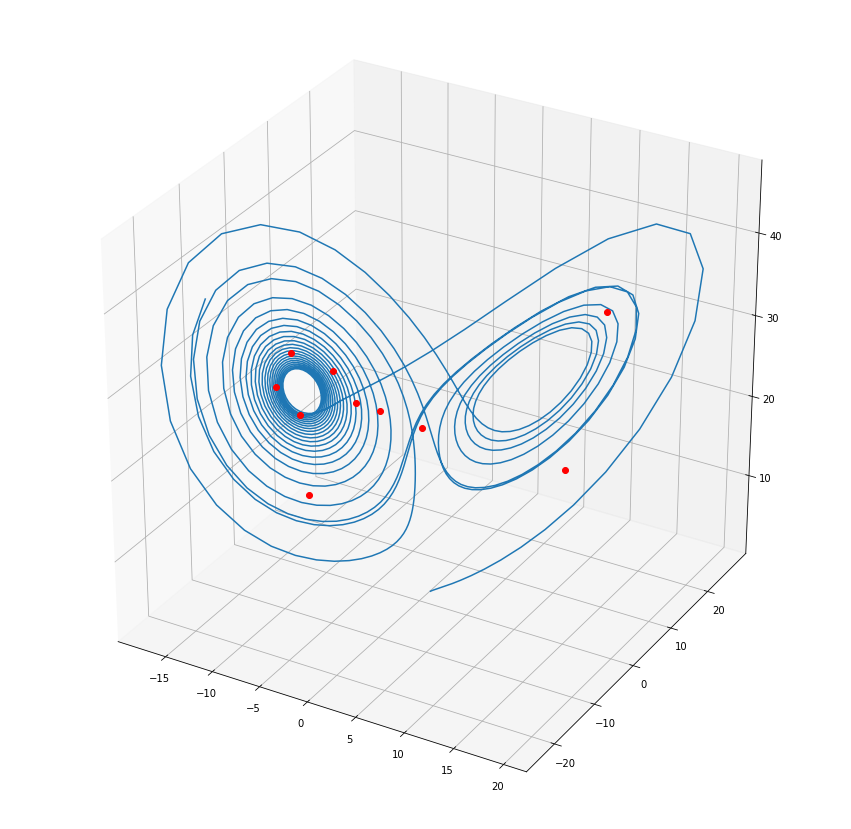

In [115]:
# trivial Ensemble Kalman filter for Lorenz attractor


# start by building a model
from scipy.integrate import odeint

rho = 28
sigma = 10
beta = 8/3

def f(X, t):
    """ Put the Forward Euler right hand side for Lorenz attractor"""
    
    x = X.reshape(3, len(X)//3)
    
    y = np.empty(x.shape)
    
    y[0, :] = sigma*(x[1, :]-x[0, :])
    y[1, :] = -x[0, :]*x[2, :] + rho*x[0, :]-x[1, :]
    y[2, :] = x[0, :]*x[1, :] - beta*x[2, :]
    
    return y.ravel()

x0 = np.ones(3)
t = np.linspace(0, 20, 1001)

x_t = odeint(f, x0, t).reshape(1001, 3)
    
fig = p.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*x_vec[:,0:3].T)

y = x_t[100::100, 0] + np.random.normal(0, 0.1, 10)

H =np.zeros((1, 3))
H[0, 0] = 1

p.plot(y, *x_t[100::100, 1:].T , 'ro')

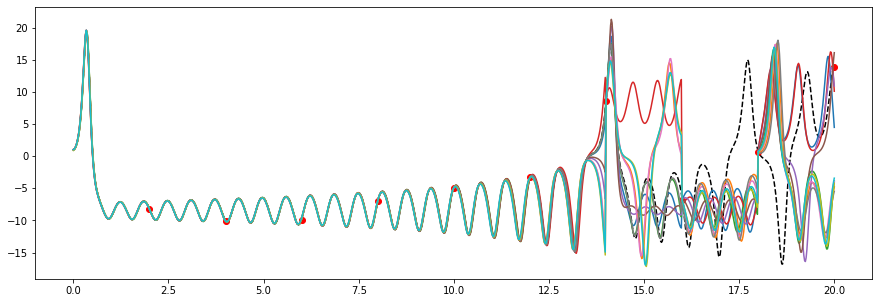

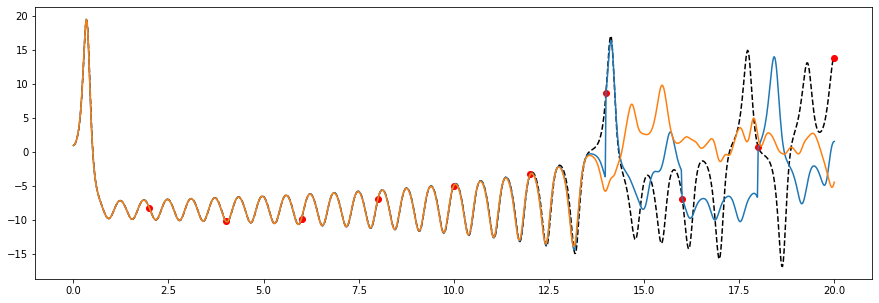

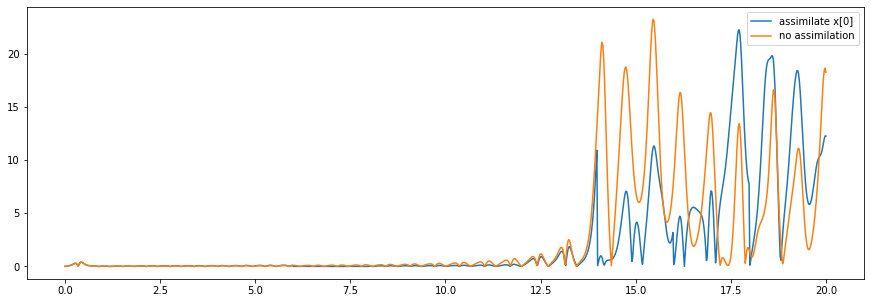

In [145]:
N = 10

x_b0 = np.ones(3) + np.random.normal(0, 0.05, 3)
X_b0 = np.tile(x_b0, (N, 1)).T + np.random.normal(0, 0.05, (3, N))

X_b = np.empty([len(t), 3, N])


def C(X):
    Xmean = np.mean(X, axis=1)
    A = X - np.tile(Xmean, (N, 1)).T
    return A.dot(A.T)/(N-1)

X_b[:101, ...] = odeint(f, X_b0.ravel(), t[:101]).reshape(101, 3, N)
X_f = odeint(f, X_b0.ravel(), t).reshape(1001, 3, N)
for i in range(1, 10):
    Z = np.tile(y[i-1], (N, 1)).T - H.dot(X_b[i*100, :, :]) + np.random.normal(0, 0.1, (1, N))
    B = C(X_b[i*100, :, :])
    K = B.dot(H.T)*inv((H.dot(B.dot(H.T))+0.1**2))
    X_a = X_b[i*100, :, :] + K.dot(Z)
    X_b[i*100:(i+1)*100+1, ...] = odeint(f, X_a.ravel(), t[i*100:(i+1)*100+1]).reshape(101, 3, N)

t_y=0
    
p.figure(figsize=(15,5))
p.plot(t, x_t[:, 0], 'k--')
p.plot(t[100::100], y,'ro')
p.plot(t, X_b[:, 0,],)
p.figure(figsize=(15,5))
p.plot(t, x_t[:, 0], 'k--')
p.plot(t[100::100], y,'ro')
p.plot(t, np.mean(X_b[:, 0, :], axis=1),)
p.plot(t, np.mean(X_f[:, 0, :], axis=1),)
p.figure(figsize=(15,5))
p.plot(t, (abs(np.mean(X_b[:, 0, :], axis=1)-x_t[:, 0])), label='assimilate x[0]')
p.plot(t, (abs(np.mean(X_f[:, 0, :], axis=1)-x_t[:, 0])), label='no assimilation')
p.legend()

    

## Further Reading

- Daley - Atmospheric Data Analysis
- Kalnay - Atmospheric modeling, data assimilation and predictability
- Bennett - Inverse Modeling of the Ocean and Atmosphere
- F. Bouttier and P. Courtier : [Data assimilation concepts and methods](https://www.ecmwf.int/en/elibrary/16928-data-assimilation-concepts-and-methods) - ECMWF Lecture notes
- Press, Teukolsky, Vetterin & Flannery - Numerical Recipes (for a deep discussion of random number generators)